# Separating Mouse and Human Antibody Sequences using Protein Encoding and Machine Learning Classifiers

### Questions:

- How may we create a machine learning classifier that can tell apart two groups of proteins?

- How may we check for overfitting in a trained machine learning classifier?


### Objectives:
    
- Understand how protein sequences can become readable to machine learning predictors

- Check for overfitted data by testing with a totally naive dataset


### Introduction 

If we want to generate a classifier that observes the differences between two groups of protein seequences, then we need to extract numerical information from our sequences. This is called encoding and can be done through a variety of ways inlcuding residue level encoding of each amino acid in your sequences with a 1x20 vector, representing the possibility of 20 amino acids at each residue. This is called One Hot Encoding, but often leads to a sparse dataset which is not suitable for machine learning tasks, and each sequence must be spaced out so they are of equal length. Instead, in this example we use the physiochemical properties that may be calculated from the sequence as our numeric information (ElAbd *et al.*, 2020). 

Antibodies are made up of two heavy and two light chains, however, the functional antigen-binding domains are Fv fragments at each fork of the "Y" shape. These Fv fragments are where the VH domain of a heavy chain and VL domain of a light chain interact and so much study has been dedicated to these regions. An antibody record is considered "paired" when both the VH and VL sequences of one antibody are known. This knowledge was rare in the past and came from studying individual antibodies, however, the advent of B-cell encapsulation and Next Generation Sequencing now allowed researchers to sequence a repertoire of paired antibodies (Rajan *et al.*, 2018).

In this exercise, we will use a sample of 1000 Human and 1000 Mouse paired antibodies taken from the Observed Antibody Space (Olsen *et al.*, 2022) and develop a machine learning classifier to separate them. Firstly, we will use Kidera Factors (Nakai *et al.*, 1988) and Propythia (Sequeira *et al.*, 2022) to generate our encodings from an input of Fasta formatted sequences. Secondly, we will split those encodings into training and test datasets for a selection of machine learning classifiers and plot our results, comparing both methods of encodings.

### References

ElAbd, H., Bromberg, Y., Hoarfrost, A., Lenz, T., Franke, A., & Wendorff, M. (2020). Amino acid encoding for deep learning applications. BMC Bioinformatics, 21(1), 235. https://doi.org/10.1186/s12859-020-03546-x

Nakai, K., Kidera, A., & Kanehisa, M. (1988). Cluster analysis of amino acid indices for prediction of protein structure and function. Protein Engineering, Design and Selection, 2(2), 93-100 https://doi.org/10.1093/protein/2.2.93

Olsen, T. H., Boyles, F., & Deane, C. M. (2022). Observed Antibody Space: A diverse database of cleaned, annotated, and translated unpaired
and paired antibody sequences. Protein Science, 31(1), 141–146. https://doi.org/https://doi.org/10.1002/pro.4205

Rajan, S., Kierny, M. R., Mercer, A., Wu, J., Tovchigrechko, A., Wu, H., Dall′Acqua, W. F., Xiao, X., & Chowdhury, P. S. (2018). Recombinant
human B cell repertoires enable screening for rare, specific, and natively paired antibodies. Communications Biology, 1(1), 5. https://doi.org/10.1038/s42003-017-0006-2

Sequeira, A. M., Lousa, D., & Rocha, M. (2022). ProPythia: A Python package for protein classification based on machine and deep learning.
Neurocomputing, 484, 172–182. https://doi.org/https://doi.org/10.1016/j.neucom.2021.07.102


## Imports and Requirements
The antibody encoding method we will be using is the Propythia program. Before starting we recommend installing it by copying and pasting the following command in your terminal/command line:

`pip install propythia`

The machine learning models that we will use are imported from the sklearn package. We also suggest installing this via the following command: 

`pip install sklearn`

As this is a large package, rather than importing the whole package, it is better practise to just import the fuctions we require. As this usually leaves with a lot of import statements, we have broken them down what imports are required at what stage of the process.

In [5]:
##Get Encodings###
import sys
import pandas as pd
from pandas import read_csv
sys.path.append('../src/')
sys.path.append('')
from propythia.sequence import ReadSequence
sequence=ReadSequence()
from propythia.descriptors import Descriptor


##Data preparation###
from sklearn.utils import check_random_state, shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy import pi, linspace, cos, sin, append, ones, zeros, hstack, vstack, intp
from numpy import mgrid, linspace, c_, arange, mean, array
from numpy.random import uniform, seed


##Machine Learning Models###
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation


##Plotting Results###
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits import mplot3d
from matplotlib.pyplot import subplots, axes, scatter, xticks
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef


##Model Optimisation###
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


In [32]:
n=2
RANDOM_SEED=42



#    'KNeighbours': KNeighborsClassifier(2),
 #   'Guassian':GaussianMixture(n_components=n),
 #   'KMeans': KMeans(n_clusters=n) ,

classifiers = {
    'SVC':SVC(kernel="linear", C=0.025),
    'SVC2': SVC(gamma=2, C=1),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RFC': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'MLPC': MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    'ADABoost':AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QDA':QuadraticDiscriminantAnalysis(),
}


## Generating the Encoded Dataset


Here we input our fasta file and split the entries into VH and VL sequences. We put each set of sequecnes through the Propythia encoder a dataframe of numerical information for both VH and VL sequences. There are 4000 records in the fasta file representing 2000 paired antibodies: 1000 human and 1000 mouse.

In [36]:
def Get_Kidera_Encoded_Sequences(fasta):
    VH_sequences = []
    VL_sequences = []
    Kidera_Factors = {"A": [-1.56,-1.67,-0.97,-0.27,-0.93,-0.78,-0.20,-0.08,0.21,-0.48], "R": [0.22,1.27,1.37,1.87,-1.70,0.46,0.92,-0.39,0.23,0.93], "N": [1.14,-0.07,-0.12,0.81,0.18,0.37,-0.09,1.23,1.10,-1.73], "D": [0.58,-0.22,-1.58,0.81,-0.92,0.15,-1.52,0.47,0.76,0.70], "C": [0.12,-0.89,0.45,-1.05,-0.71,2.41,1.52,-0.69,1.13,1.10], "Q": [-0.47,0.24,0.07,1.10,1.10,0.59,0.84,-0.71,-0.03,-2.33], "E": [-1.45,0.19,-1.61,1.17,-1.31,0.40,0.04,0.38,-0.35,-0.12], "G": [1.46,-1.96,-0.23,-0.16,0.10,-0.11,1.32,2.36,-1.66,0.46], "H": [-0.41,0.52,-0.28,0.28,1.61,1.01,-1.85,0.47,1.13,1.63], "I": [-0.73,-0.16,1.79,-0.77,-0.54,0.03,-0.83,0.51,0.66,-1.78], "L": [-1.04,0.00,-0.24,-1.10,-0.55,-2.05,0.96,-0.76,0.45,0.93], "K": [-0.34,0.82,-0.23,1.70,1.54,-1.62,1.15,-0.08,-0.48,0.60], "M": [-1.40,0.18,-0.42,-0.73,2.00,1.52,0.26,0.11,-1.27,0.27], "F": [-0.21,0.98,-0.36,-1.43,0.22,-0.81,0.67,1.10,1.71,-0.44], "P": [2.06,-0.33,-1.15,-0.75,0.88,-0.45,0.30,-2.30,0.74,-0.28], "S": [0.81,-1.08,0.16,0.42,-0.21,-0.43,-1.89,-1.15,-0.97,-0.23], "T": [0.26,-0.70,1.21,0.63,-0.10,0.21,0.24,-1.15,-0.56,0.19], "W": [0.30,2.10,-0.72,-1.57,-1.16,0.57,-0.48,-0.40,-2.30,-0.60], "Y": [1.38,1.48,0.80,-0.56,-0.00,-0.68,-0.31,1.03,-0.05,0.53], "V": [-0.74,-0.71,2.04,-0.40,0.50,-0.81,-1.07,0.06,-0.46,0.65], "X": [0,0,0,0,0,0,0,0,0,0]}
    with open(fasta, "r") as f:
        for line in f:
            if line[0] == ">":
                if "_VH" in line:
                    sequence_to_add = f.readline().strip()
                    VH_sequences.append(sequence_to_add)
                elif "_VL" in line:
                    sequence_to_add = f.readline().strip()
                    VL_sequences.append(sequence_to_add)

    if len(VH_sequences) == len(VL_sequences):
        VH_encodings = []
        VL_encodings = []
        for i in range(len(VH_sequences)):
            VH_kidera = []
            for res in VH_sequences[i]:
                VH_kidera = VH_kidera + Kidera_Factors[res]
            VH_encodings.append(VH_kidera)
        for i in range(len(VL_sequences)):
            VL_kidera = []
            for res in VL_sequences[i]:
                VL_kidera = VL_kidera + Kidera_Factors[res]
            VL_encodings.append(VL_kidera)
    VH_dataframe = pd.DataFrame(VH_encodings)
    VL_dataframe = pd.DataFrame(VL_encodings)
    # Now we join these two dataframes together so that each sample now has information about its VH and VL sequence.
    VH_dataframe_suffix = VH_dataframe.add_suffix('_VH')
    VL_dataframe_suffix = VL_dataframe.add_suffix('_VL')
    joined_dataframe_VH_VL =  VH_dataframe_suffix.join(VL_dataframe_suffix)
    joined_dataframe_VH_VL_cleaned = joined_dataframe_VH_VL.dropna(axis=1)
    return(joined_dataframe_VH_VL_cleaned)


In [37]:
input_fasta = './HumanMouseOAS_VH_VL_paired_data.faa'

joined_dataframe_VH_VL = Get_Kidera_Encoded_Sequences(input_fasta)
print(joined_dataframe_VH_VL)

      0_VH  1_VH  2_VH  3_VH  4_VH  5_VH  6_VH  7_VH  8_VH  9_VH  ...  720_VL   
0    -0.47  0.24  0.07  1.10  1.10  0.59  0.84 -0.71 -0.03 -2.33  ...   -1.56  \
1    -0.47  0.24  0.07  1.10  1.10  0.59  0.84 -0.71 -0.03 -2.33  ...   -1.04   
2    -1.45  0.19 -1.61  1.17 -1.31  0.40  0.04  0.38 -0.35 -0.12  ...    0.26   
3    -1.45  0.19 -1.61  1.17 -1.31  0.40  0.04  0.38 -0.35 -0.12  ...   -1.56   
4    -0.47  0.24  0.07  1.10  1.10  0.59  0.84 -0.71 -0.03 -2.33  ...    1.46   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...     ...   
1995 -0.47  0.24  0.07  1.10  1.10  0.59  0.84 -0.71 -0.03 -2.33  ...    1.46   
1996 -1.45  0.19 -1.61  1.17 -1.31  0.40  0.04  0.38 -0.35 -0.12  ...    0.81   
1997 -0.47  0.24  0.07  1.10  1.10  0.59  0.84 -0.71 -0.03 -2.33  ...   -1.04   
1998 -0.47  0.24  0.07  1.10  1.10  0.59  0.84 -0.71 -0.03 -2.33  ...   -1.56   
1999 -1.45  0.19 -1.61  1.17 -1.31  0.40  0.04  0.38 -0.35 -0.12  ...    0.81   

      721_VL  722_VL  723_V

Now we have our encodings, we need to prepare our labels. As our input was ordered 1000 Human antibodies and 1000 Mouse antibodies we can simply make a list showing only these:

In [38]:
#Prepare training data and labels
labels1 = 1000*[1] ##Human antibodies will be class 1
labels2 = 1000*[0] ## Mouse antibodies will be class 0
labels = labels1+labels2
y=labels
print(len(y))
##Mouse ==1, Human == 0

dataset = joined_dataframe_VH_VL
dataset=dataset.loc[:, dataset.columns != 'Unnamed: 0']
print(dataset.shape) ##Just to check that you have an equal number of labels to the number of samples


2000
(2000, 1780)


Now that we have our datasets, we may not split them into training datasets for fitting our classifiers to and training datasets to verify their effectiveness as predictors. Usually 70/30 or 80/20 split is necessary.

In [39]:

X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train.shape, "       Test set size: ", X_test.shape)


Training set size:  (1400, 1780)        Test set size:  (600, 1780)


## Separating our data with Machine Learning Classifiers
Here is our list of classifiers that we will loop through to see which is the best at clustering our dataset:

Now loop over our classifiers and use the test and train datasets to generate a score to validate the classifiers. I have chosen Matthews Correlation Coefficient (MCC) which is a metric less prone to bias by taking into account false predictions, as well as true predictions. This metric lies on a score between -1 (inverse prediction) and 1 (perfect prediction) with 0 being coin toss likelihood. We then plot our results as a confusion matrix which demonstrates the predictive power of our classifiers. The Confusion matrix shows the raw number of records that have been assigned to each category in a 2x2 matrix and is given as such: 

|                  | Predicted Class = 0  | Predicted Class = 1 |
|------------------|----------------------|---------------------|
| Actual Class = 0 | True Negative        | False Positive      |
| Actual Class = 1 |  False Negative      | True Positive       |

Ideally we want the True Negative and True Positive field to be the most popular fields with only a few records in the false positive fields.

N.B.: Results may vary between each run due to the stochastic nature of the machine learning algorithms.

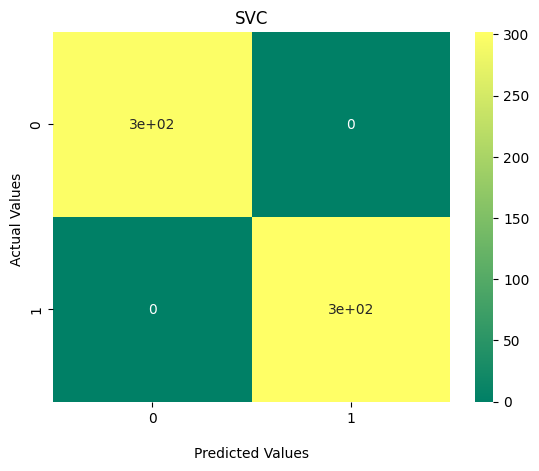

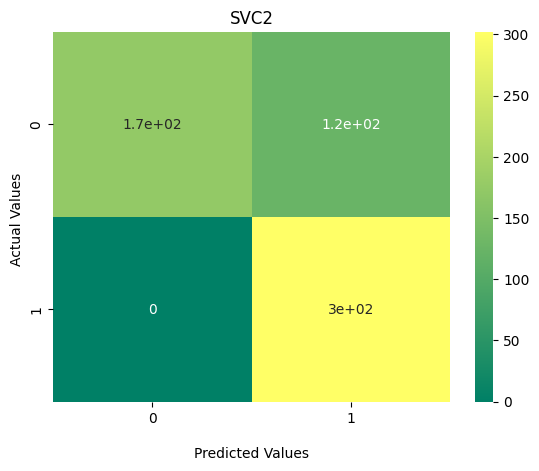

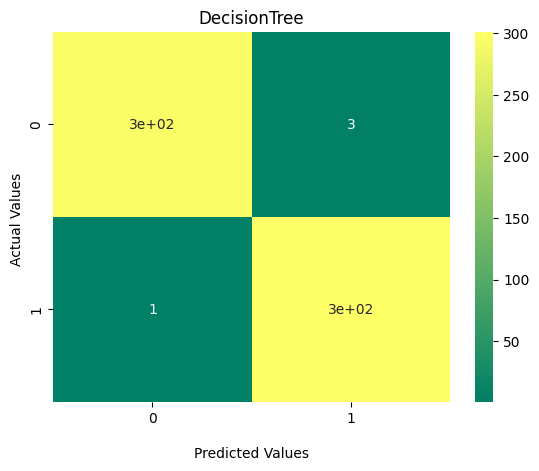

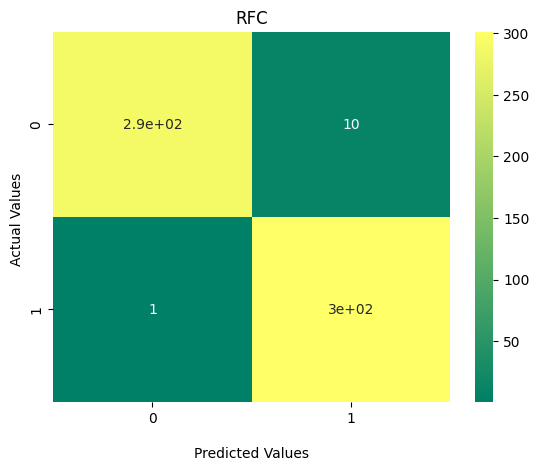

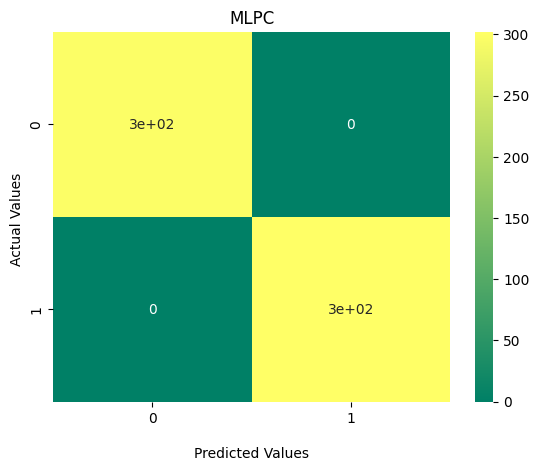

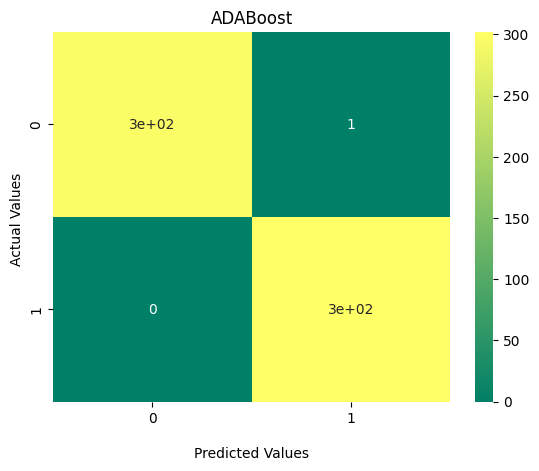

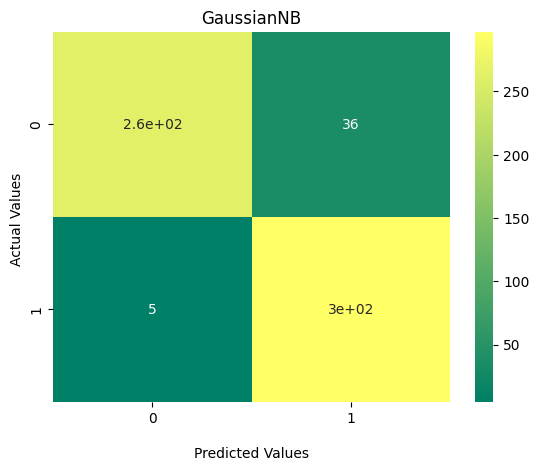

/Users/james/anaconda3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


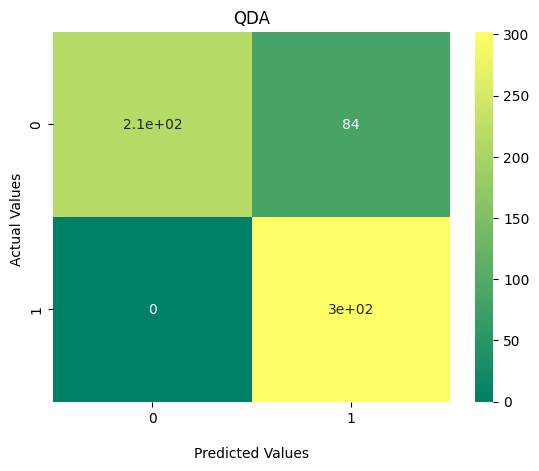

In [40]:
##Loop through each classifier, fit training data and evaluate model. Plot results as confusion matrix##
scores = []

for i in classifiers:
    clf_1 = classifiers.get(i)
    clf_1.fit(X_train,y_train)
    y_predict1 = clf_1.predict(X_test)
    scoring = matthews_corrcoef(y_test, y_predict1)
    scores.append(scoring) 
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict1)
    ax1 = sns.heatmap(confusion_matrix, annot=True, cmap='summer')
    title = str(i)
    ax1.set_title(title);
    ax1.set_xlabel('\nPredicted Values')
    ax1.set_ylabel('Actual Values ');
    plt.show()



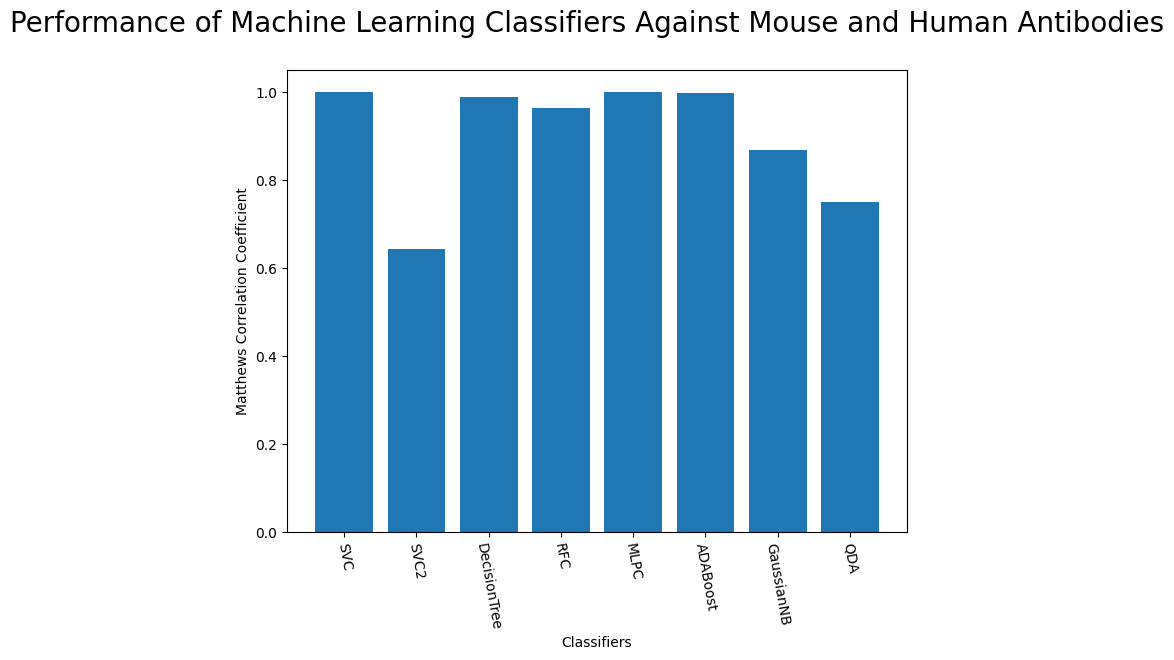

In [41]:
##Plot Performance of all Models##
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies', fontsize=20)

bins = arange(len(classifiers))
ax.bar(arange(len(scores)), scores)
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Classifiers')
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=-80);

As we can see, the majority of these classifiers have been very successful at training on the data and learning to classify the two groups, with nearly perfect performance in the SVC model and ADABoost. What we can assume from this is that there are highly correlated features in the training data which the models have used for training. However, the Kidera factor is not the only method of encoding sequences for machine learning algorithms. In fact, for more complicated problems, usually deeper methods of encodings are required.

### Using Amino Acid Compositions to Encode Preotein Sequences

Amino acid compositions are more sequence based statistics than the physiochemical properties evaluated in the Kidera factors. These generate much denser and complex encodings which we will compare with the Kidera factor method. 

In [ ]:
###Propythia Command to get encodings###
def get_descriptors(protein):
    ##This will retrieve a selection of encodings that are not dependent on the sequence length##
    test= protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21])
    return(test)

In [ ]:
def Get_dataset(fasta):
    VH_sequences = []
    VL_sequences = []
    with open(fasta, "r") as f:
        for line in f:
            if line[0] == ">":
                if "_VH" in line:
                    sequence_to_add = f.readline().strip()
                    VH_sequences.append(sequence_to_add)
                elif "_VL" in line:
                    sequence_to_add = f.readline().strip()
                    VL_sequences.append(sequence_to_add)

    print(len(VH_sequences),len(VL_sequences))
    if len(VH_sequences) == len(VL_sequences):
        VH_dataframe = pd.DataFrame()
        VL_dataframe = pd.DataFrame()
        for i in range(len(VH_sequences)):
            ps_string=sequence.read_protein_sequence(VH_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            #VH_dataframe.loc[len(VH_dataframe)] = descriptors
            VH_dataframe = VH_dataframe._append(descriptors, ignore_index=True)
        print("VH_data", VH_dataframe.shape)
        for i in range(len(VL_sequences)):
            ps_string=sequence.read_protein_sequence(VL_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            #VL_dataframe.loc[len(VL_dataframe)] = descriptors
            VL_dataframe = VL_dataframe._append(descriptors, ignore_index=True)
        print("VL_data", VL_dataframe.shape)
    # Now we join these two dataframes together so that each sample now has information about its VH and VL sequence.
    VH_dataframe_suffix = VH_dataframe.add_suffix('_VH')
    VL_dataframe_suffix = VL_dataframe.add_suffix('_VL')
    joined_dataframe_VH_VL =  VH_dataframe_suffix.join(VL_dataframe_suffix)
    return(joined_dataframe_VH_VL)


In [3]:
### Input Fasta and Run Dataset###
input_fasta = './HumanMouseOAS_VH_VL_paired_data.faa'

#joined_dataframe_VH_VL = Get_dataset(input_fasta)

#Optionally save dataframe as a CSV to simply reload it in future
#joined_dataframe_VH_VL.to_csv('./HumanMouseOAS_VH_VL_paired_data.faa_Full_descriptors')#
joined_dataframe_VH_VL = read_csv('./HumanMouseOAS_VH_VL_paired_data.faa_Full_descriptors.csv', header = 0)

### Do it yourself
- These encodings used with Propythia were selected to reduce the time taken to run. Retry the encoding step and experiment with the protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21]) array.

- NB Propythia accepts numbers 0-40 however we avoid 1, 2 and 37 as these produce outputs of differing length

In [4]:
RANDOM_SEED = 0
#Prepare training data and labels
labels1 = 1000*[1] ##Human antibodies will be class 1
labels2 = 1000*[0] ## Mouse antibodies will be class 0
labels = labels1+labels2
y=labels
print(len(y))
##Mouse ==1, Human == 0

dataset = joined_dataframe_VH_VL
dataset=dataset.loc[:, dataset.columns != 'Unnamed: 0']
print(dataset.shape) ##Just to check that you have an equal number of labels to the number of samples


2000
(2000, 890)


In [5]:

X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train.shape, "       Test set size: ", X_test.shape)


Training set size:  (1400, 890)        Test set size:  (600, 890)


In [6]:
n=2
RANDOM_SEED=42



#    'KNeighbours': KNeighborsClassifier(2),
 #   'Guassian':GaussianMixture(n_components=n),
 #   'KMeans': KMeans(n_clusters=n) ,

classifiers = {
    'SVC':SVC(kernel="linear", C=0.025),
    'SVC2': SVC(gamma=2, C=1),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RFC': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'MLPC': MLPClassifier(alpha=1, max_iter=1000),
    'ADABoost':AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QDA':QuadraticDiscriminantAnalysis(),
}


### Do it yourself
- This is not an exhaustive list of classifiers. These were mostly picked to represent all of the different kinds of models. 
Here you will find a much larger list of classifiers. Try adding some to the classifiers dictionary and see how the results differ.
Additional models that are supported in scikit learn can be found here: https://scikit-learn.org/stable/supervised_learning.html

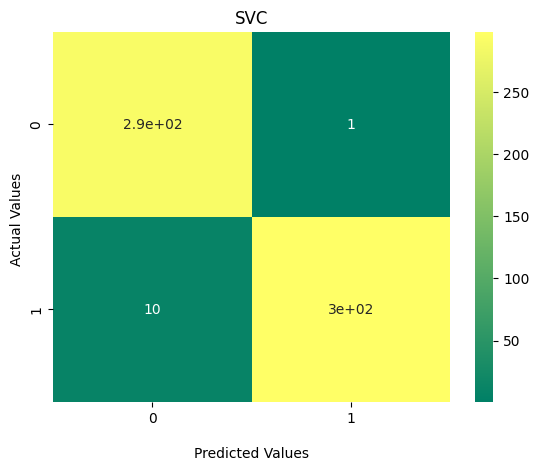

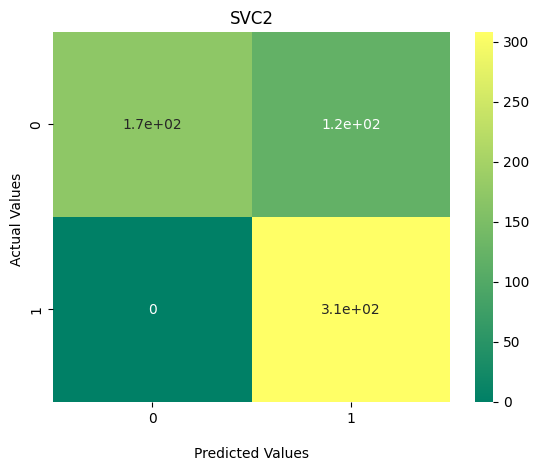

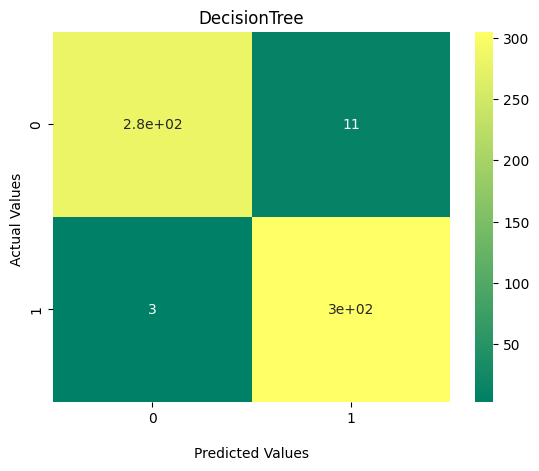

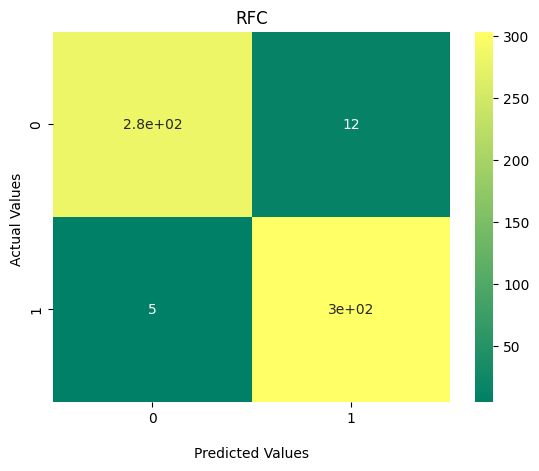

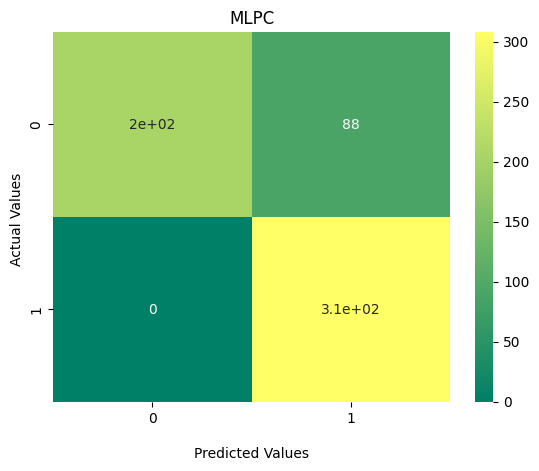

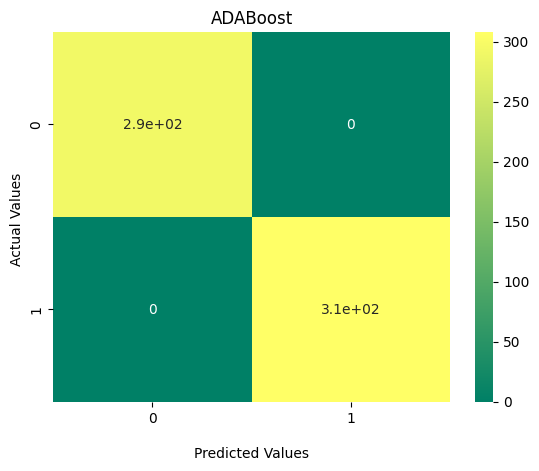

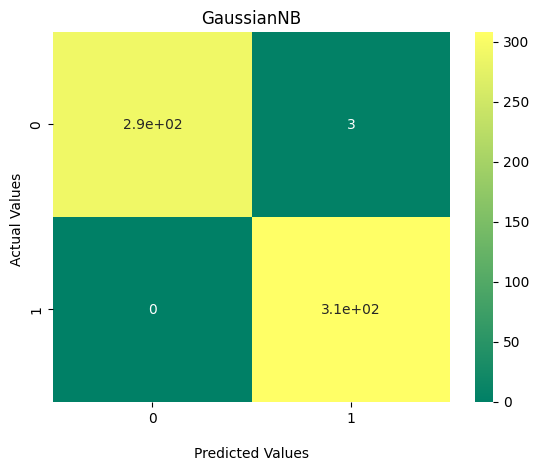

/Users/james/anaconda3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


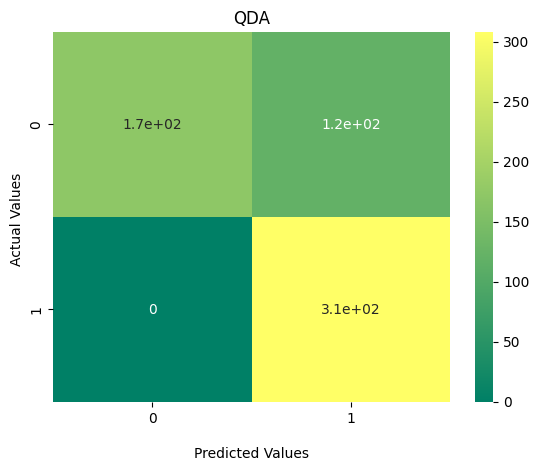

In [7]:
##Loop through each classifier, fit training data and evaluate model. Plot results as confusion matrix##
scores = []

for i in classifiers:
    clf_1 = classifiers.get(i)
    clf_1.fit(X_train,y_train)
    y_predict1 = clf_1.predict(X_test)
    scoring = matthews_corrcoef(y_test, y_predict1)
    scores.append(scoring) 
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict1)
    ax1 = sns.heatmap(confusion_matrix, annot=True, cmap='summer')
    title = str(i)
    ax1.set_title(title);
    ax1.set_xlabel('\nPredicted Values')
    ax1.set_ylabel('Actual Values ');
    plt.show()



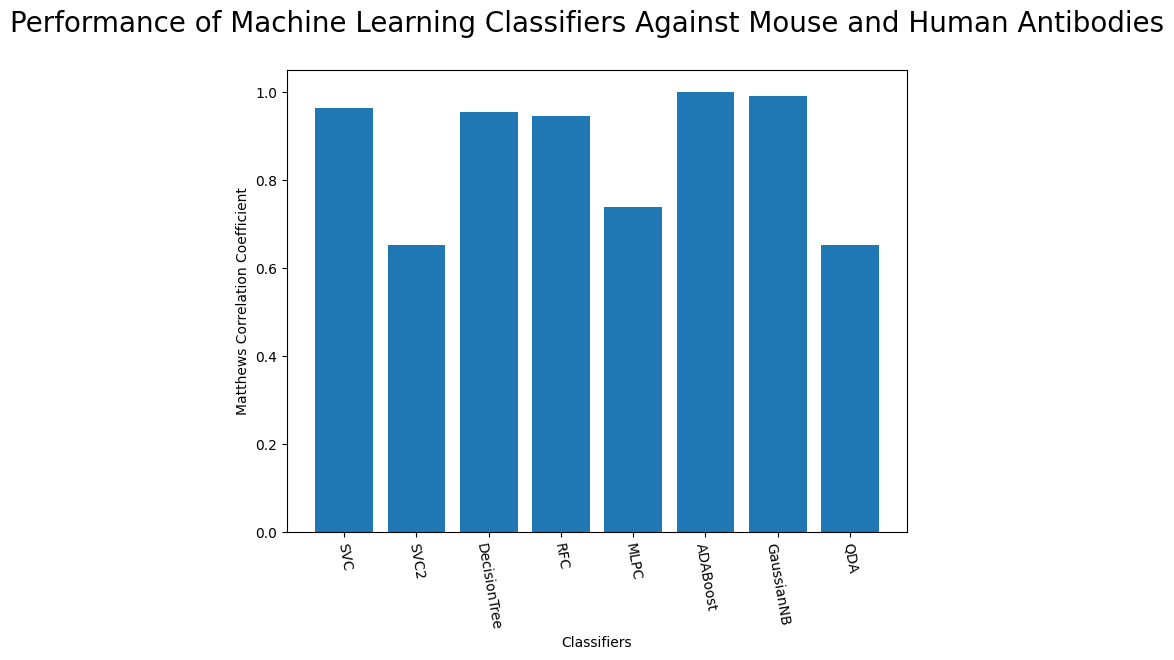

In [8]:
##Plot Performance of all Models##
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies', fontsize=20)

bins = arange(len(classifiers))
ax.bar(arange(len(scores)), scores)
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Classifiers')
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=-80);

From the above chart, we can see that the best performing predictors are ADA_Boost, GaussinNB, DecisionTree and SVC are the best performing classifier, wheras both Gaussian and KMeans are the worst performing with negative MCC scores.


### Questions
- Which encoding method produced overall the best results? Why could this be? Hint: think of the size of both sets of encodings
- What could be the advantages and disadvantages of both sets of encodings?

## End of Chapter Exercise: Testing our Classifiers on a Naïve Dataset

We have seen that it is possible to separate mouse and human antibody protein sequences through their numerical encodings.

We can also take a totally naïve dataset that the model has not been exposed to. This is a measure that checks for overfitting. If we see that there is poor performance on this naïve "held back" dataset, then it could suggest overfitting to the training data. Using 20 Human and 20 mouse paired sequences from OAS, which were not used to train our models, it is possible to generate their encodings, and pass them through the optimised model, in order to test it.  

The file below has 20 human and 20 mouse sequences which are held back from our original training data. Using the skills you have learned so far in this notebook, encode these paired sequences and generate a list of labels for these entries. Pass them through the trained classifiers and evaluate their performance.

- Comment on which classifier performs best.
- Think of ways in which the classifiers can be improved. These will be expanded upon in the next Notebook.

`naive_fasta = './Naive_dataset.faa.txt'`


## Keypoints

- Protein sequences must be numerically encoded to be readable by machine learning algorithms.
- It is necessary to test your classifier with multiple models and multiple encoding methods to find which works the best